In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torchvision

# 为再现性设置随机seem
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 如果你想要新的结果就是要这段代码
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
dataroot = "./.keras/datasets/flower_photos"#########################################################
workers = 2
batch_size = 32
image_size = 180

In [3]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# 创建加载器
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
full_dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_all_size = int(0.9 *len(full_dataset))
test_size = len(full_dataset) - train_all_size
train_all_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_all_size, test_size])

In [5]:
print(train_all_size,test_size)

3303 367


In [6]:
train_size =int(0.8*train_all_size)
vali_size = train_all_size - train_size
train_dataset, vali_dataset = torch.utils.data.random_split(train_all_dataset, [train_size, vali_size])

In [7]:
print(train_size,vali_size)

2642 661


In [9]:
traindataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [10]:
validataloader = torch.utils.data.DataLoader(vali_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [11]:
j=0
for data in traindataloader:
    images, labels = data
    print(j+1,images.shape)
    j=j+1

1 torch.Size([32, 3, 180, 180])
2 torch.Size([32, 3, 180, 180])
3 torch.Size([32, 3, 180, 180])
4 torch.Size([32, 3, 180, 180])
5 torch.Size([32, 3, 180, 180])
6 torch.Size([32, 3, 180, 180])
7 torch.Size([32, 3, 180, 180])
8 torch.Size([32, 3, 180, 180])
9 torch.Size([32, 3, 180, 180])
10 torch.Size([32, 3, 180, 180])
11 torch.Size([32, 3, 180, 180])
12 torch.Size([32, 3, 180, 180])
13 torch.Size([32, 3, 180, 180])
14 torch.Size([32, 3, 180, 180])
15 torch.Size([32, 3, 180, 180])
16 torch.Size([32, 3, 180, 180])
17 torch.Size([32, 3, 180, 180])
18 torch.Size([32, 3, 180, 180])
19 torch.Size([32, 3, 180, 180])
20 torch.Size([32, 3, 180, 180])
21 torch.Size([32, 3, 180, 180])
22 torch.Size([32, 3, 180, 180])
23 torch.Size([32, 3, 180, 180])
24 torch.Size([32, 3, 180, 180])
25 torch.Size([32, 3, 180, 180])
26 torch.Size([32, 3, 180, 180])
27 torch.Size([32, 3, 180, 180])
28 torch.Size([32, 3, 180, 180])
29 torch.Size([32, 3, 180, 180])
30 torch.Size([32, 3, 180, 180])
31 torch.Size([32, 

In [12]:
j=0
for data in validataloader:
    images, labels = data
    print(j+1,images.shape)
    j=j+1

1 torch.Size([32, 3, 180, 180])
2 torch.Size([32, 3, 180, 180])
3 torch.Size([32, 3, 180, 180])
4 torch.Size([32, 3, 180, 180])
5 torch.Size([32, 3, 180, 180])
6 torch.Size([32, 3, 180, 180])
7 torch.Size([32, 3, 180, 180])
8 torch.Size([32, 3, 180, 180])
9 torch.Size([32, 3, 180, 180])
10 torch.Size([32, 3, 180, 180])
11 torch.Size([32, 3, 180, 180])
12 torch.Size([32, 3, 180, 180])
13 torch.Size([32, 3, 180, 180])
14 torch.Size([32, 3, 180, 180])
15 torch.Size([32, 3, 180, 180])
16 torch.Size([32, 3, 180, 180])
17 torch.Size([32, 3, 180, 180])
18 torch.Size([32, 3, 180, 180])
19 torch.Size([32, 3, 180, 180])
20 torch.Size([32, 3, 180, 180])
21 torch.Size([21, 3, 180, 180])


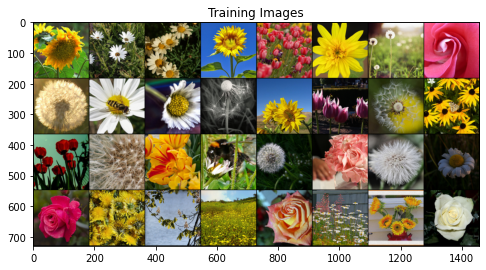

In [13]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:180], padding=2, normalize=True).cpu(),(1,2,0)))

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # layers.Rescaling(
        self.conv1 = nn.Conv2d(3, 16, 3,padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3,padding='same')
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(22*22*64, 128)
        self.fc2 = nn.Linear(128, 5)
      
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 22*22*64)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [15]:
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=30976, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999),eps=1e-08)

In [17]:
classes=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [18]:
all_losses = []
for epoch in range(10):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(traindataloader, 0):
        #print(i)
        inputs, labels = data
       # print(inputs.shape,labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 83== 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 83))
            all_losses.append(running_loss/83)
            running_loss = 0.0
    
    net.eval()
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))
    j=0
    with torch.no_grad():
        for data in validataloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            j+=1
            if(j<=20):
                for i in range(32):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
            if(j==21):
                for i in range(21):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
            

    correct=0
    total=0
    for i in range(5):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        correct+=class_correct[i]
        total+=class_total[i]
    
    print(correct/total*100)
    
    

print('Finished Training')

[1,    83] loss: 1.330
Accuracy of daisy : 16 %
Accuracy of dandelion : 67 %
Accuracy of roses : 33 %
Accuracy of sunflowers : 74 %
Accuracy of tulips : 43 %
49.62178517397882
[2,    83] loss: 1.102
Accuracy of daisy : 45 %
Accuracy of dandelion : 75 %
Accuracy of roses : 64 %
Accuracy of sunflowers : 55 %
Accuracy of tulips : 29 %
54.46293494704992
[3,    83] loss: 0.984
Accuracy of daisy : 64 %
Accuracy of dandelion : 79 %
Accuracy of roses : 37 %
Accuracy of sunflowers : 63 %
Accuracy of tulips : 47 %
60.363086232980336
[4,    83] loss: 0.878
Accuracy of daisy : 70 %
Accuracy of dandelion : 82 %
Accuracy of roses : 44 %
Accuracy of sunflowers : 53 %
Accuracy of tulips : 44 %
60.514372163388806
[5,    83] loss: 0.769
Accuracy of daisy : 67 %
Accuracy of dandelion : 80 %
Accuracy of roses : 53 %
Accuracy of sunflowers : 80 %
Accuracy of tulips : 39 %
64.75037821482601
[6,    83] loss: 0.636
Accuracy of daisy : 47 %
Accuracy of dandelion : 73 %
Accuracy of roses : 18 %
Accuracy of sunf

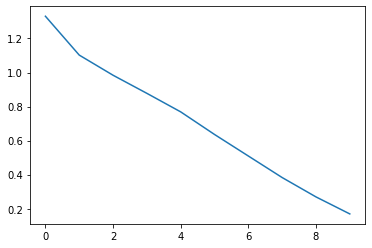

In [20]:
plt.figure()
plt.plot(all_losses)

In [21]:
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [22]:
j=0
for data in testdataloader:
    images, labels = data
    print(j+1,images.shape)
    j=j+1

1 torch.Size([32, 3, 180, 180])
2 torch.Size([32, 3, 180, 180])
3 torch.Size([32, 3, 180, 180])
4 torch.Size([32, 3, 180, 180])
5 torch.Size([32, 3, 180, 180])
6 torch.Size([32, 3, 180, 180])
7 torch.Size([32, 3, 180, 180])
8 torch.Size([32, 3, 180, 180])
9 torch.Size([32, 3, 180, 180])
10 torch.Size([32, 3, 180, 180])
11 torch.Size([32, 3, 180, 180])
12 torch.Size([15, 3, 180, 180])


In [25]:
with torch.no_grad():
    for data in testdataloader:
        images, labels = data
        outputs = net(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        j+=1
        if(j<=11):
            for i in range(32):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        if(j==12):
            for i in range(15):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            

correct=0
total=0
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    correct+=class_correct[i]
    total+=class_total[i]
    
print(correct/total*100)

Accuracy of daisy : 62 %
Accuracy of dandelion : 67 %
Accuracy of roses : 36 %
Accuracy of sunflowers : 68 %
Accuracy of tulips : 68 %
62.32980332829047
